# Generative Adversarial Network
# 生成对抗网络


In this notebook, we'll be building a generative adversarial network (GAN) trained on the MNIST dataset. From this, we'll be able to generate new handwritten digits!
> 在这本笔记本中，我们将建立一个针对MNIST数据集训练的生成对抗网络（GAN）。从此，我们将能够生成新的手写数字！

GANs were [first reported on](https://arxiv.org/abs/1406.2661) in 2014 from Ian Goodfellow and others in Yoshua Bengio's lab. Since then, GANs have exploded in popularity. Here are a few examples to check out:
> 来自Ian Goodfellow和Yoshua Bengio实验室的其他人员在2014年[首次报道了GAN](https://arxiv.org/abs/1406.2661)。此后，GAN已经爆炸式增长。以下是几个例子：

* [Pix2Pix](https://affinelayer.com/pixsrv/) 
* [CycleGAN](https://github.com/junyanz/CycleGAN)
* [A whole list](https://github.com/wiseodd/generative-models)

The idea behind GANs is that you have two networks, a generator $G$ and a discriminator $D$, competing against each other. The generator makes fake data to pass to the discriminator. The discriminator also sees real data and predicts if the data it's received is real or fake. The generator is trained to fool the discriminator, it wants to output data that looks _as close as possible_ to real data. And the discriminator is trained to figure out which data is real and which is fake. What ends up happening is that the generator learns to make data that is indistiguishable from real data to the discriminator.
> GAN背后的想法是，您有两个网络，一个生成器$ G $和一个鉴别器$ D $，彼此竞争。发生器使假数据传递给鉴别器。鉴别器还可以看到实际的数据，并且预测其接收到的数据是真实还是假的。发生器被训练为愚弄鉴别器，它希望将看起来尽可能近的数据输出到实际数据。并且鉴别器被训练以确定哪些数据是真实的，哪个是假的。最终发生的是，生成器学习使得从实际数据到鉴别器不可忽视的数据。

![GAN diagram](assets/gan_diagram.png)

The general structure of a GAN is shown in the diagram above, using MNIST images as data. The latent sample is a random vector the generator uses to contruct it's fake images. As the generator learns through training, it figures out how to map these random vectors to recognizable images that can fool the discriminator.
> GAN的一般结构如上图所示，使用MNIST图像作为数据。潜在的样本是发生器用来构成假图像的随机矢量。当生成器通过训练学习时，它会计算出如何将这些随机向量映射到可以欺骗鉴别器的可识别图像。

The output of the discriminator is a sigmoid function, where 0 indicates a fake image and 1 indicates an real image. If you're interested only in generating new images, you can throw out the discriminator after training. Now, let's see how we build this thing in TensorFlow.
> 鉴别器的输出是S形函数，其中0表示假图像，1表示真实图像。如果您只对生成新的图像感兴趣，您可以在训练后丢弃鉴别器。现在，我们来看看我们如何在TensorFlow中构建这个东西。


In [1]:
%matplotlib inline

import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Model Inputs
## 模型输入

First we need to create the inputs for our graph. We need two inputs, one for the discriminator and one for the generator. Here we'll call the discriminator input `inputs_real` and the generator input `inputs_z`. We'll assign them the appropriate sizes for each of the networks.
> 首先我们需要为我们的图形创建输入。 我们需要两个输入，一个用于鉴别器，一个用于发生器。 这里我们将调用鉴频器input_real和generator input inputs_z。 我们将为每个网络分配适当的大小。

>**Exercise:** Finish the `model_inputs` function below. Create the placeholders for `inputs_real` and `inputs_z` using the input sizes `real_dim` and `z_dim` respectively.
>> 练习：完成下面的model_inputs函数。 创建input_real和inputs_z的占位符，分别使用输入大小real_dim和z_dim。

In [3]:
def model_inputs(real_dim, z_dim):
    
    #？？？为什么shape是两维，但其中一维是None呢？难道输入的不是一张张宽高确定的图片吗？
    # mnist数据集每张图是28x28，被调整为784，
    inputs_real = tf.placeholder(dtype=tf.float32, shape=[None,real_dim], name='input_real')
    inputs_z = tf.placeholder(dtype=tf.float32, shape=[None, z_dim], name='input_z')
    
    return inputs_real, inputs_z

## Generator network

![GAN Network](assets/gan_network.png)

Here we'll build the generator network. To make this network a universal function approximator, we'll need at least one hidden layer. We should use a leaky ReLU to allow gradients to flow backwards through the layer unimpeded. A leaky ReLU is like a normal ReLU, except that there is a small non-zero output for negative input values.
> 在这里我们将构建生成器网络。 为了使这个网络成为通用函数逼近器，我们至少需要一个隐藏层。 我们应该使用一个leaky ReLU来允许梯度不受阻碍地向后流动。 一个泄漏的ReLU就像一个正常的ReLU，除了负输入值有一个小的非零输出。

#### Variable Scope

Here we need to use `tf.variable_scope` for two reasons. Firstly, we're going to make sure all the variable names start with `generator`. Similarly, we'll prepend `discriminator` to the discriminator variables. This will help out later when we're training the separate networks.
> 这里我们需要使用`tf.variable_scope`有两个原因。首先，我们要确保所有的变量名都以`generator`开头。同样，我们将在鉴别器变量前面加上`discriminator`。稍后，当我们对不同的网络进行培训时，这将有所帮助。

We could just use `tf.name_scope` to set the names, but we also want to reuse these networks with different inputs. For the generator, we're going to train it, but also **sample from it** as we're training and after training. The discriminator will need to share variables between the fake and real input images. So, we can use the `reuse` keyword for `tf.variable_scope` to tell TensorFlow to reuse the variables instead of creating new ones if we build the graph again.
> 我们可以使用`tf.name_scope`来设置名称，但是我们也想用不同的输入重新使用这些网络。 对于发电机，我们要训练它，而且当我们进行训练和训练后，**它将从中抽出来**。 鉴别器将需要在假和真实输入图像之间共享变量。所以，我们可以使用`reuse`关键字`tf.variable_scope`来告诉TensorFlow重用变量，而不是重新创建新的变量。
  
To use `tf.variable_scope`, you use a `with` statement:
```python
with tf.variable_scope('scope_name', reuse=False):
    # code here
```

Here's more from [the TensorFlow documentation](https://www.tensorflow.org/programmers_guide/variable_scope#the_problem) to get another look at using `tf.variable_scope`.
> 以下是来自[TensorFlow文档](https://www.tensorflow.org/programmers_guide/variable_scope#the_problem)的更多内容，以便使用`tf.variable_scope`来看看。

#### Leaky ReLU
TensorFlow doesn't provide an operation for leaky ReLUs, so we'll need to make one . For this you can just take the outputs from a linear fully connected layer and pass them to `tf.maximum`. Typically, a parameter `alpha` sets the magnitude of the output for negative values. So, the output for negative input (`x`) values is `alpha*x`, and the output for positive `x` is `x`:
$$
f(x) = max(\alpha * x, x)
$$
> TensorFlow不提供 leaky ReLUs的操作，所以我们需要做一个。 为此，您可以从线性完全连接的层获取输出，并将其传递到`tf.maximum`。 通常，参数`alpha`设置负值的输出值。 所以，负输入（`x`）值的输出是`alpha * x`，而正的`x`的输出是`x`：

#### Tanh Output
The generator has been found to perform the best with $tanh$ for the generator output. This means that we'll have to rescale the MNIST images to be between -1 and 1, instead of 0 and 1.
> 发现发电机的发电机输出为$ tanh $。 这意味着我们必须将MNIST图像重新缩放到-1和1之间，而不是0和1。

>**Exercise:** Implement the generator network in the function below. You'll need to return the tanh output. Make sure to wrap your code in a variable scope, with 'generator' as the scope name, and pass the `reuse` keyword argument from the function to `tf.variable_scope`.
>> **练习：**在下面的函数中实现生成器网络。 你需要返回tanh输出。 确保将代码包装在可变范围内，以'generator'作为范围名称，并将`reuse`关键字参数从函数传递给`tf.variable_scope`。

In [4]:
def generator(z, out_dim, n_units=128, reuse=False,  alpha=0.01):
    ''' Build the generator network.
    
        Arguments
        ---------
        z : Input tensor for the generator
        out_dim : Shape of the generator output
        n_units : Number of units in hidden layer
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU
        
        Returns
        -------
        out: 
    '''
    with tf.variable_scope('generator', reuse=reuse): # finish this
        # Hidden layer
        # 隐藏层没有激活函数，只是一个线性输出。自行用 leaky relu 计算激活
        h1 = tf.layers.dense(z, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(alpha * h1, h1)
        
        # Logits and tanh output
        # tf.layers.dense 参数默认值： activation=None
        logits = tf.layers.dense(h1, out_dim, activation=None)
        out = tf.tanh(logits)
        
        return out

## Discriminator
## 鉴别

The discriminator network is almost exactly the same as the generator network, except that we're using a sigmoid output layer.
> 鉴别器网络与发生器网络几乎完全相同，只是我们使用sigmoid输出层。

>**Exercise:** Implement the discriminator network in the function below. Same as above, you'll need to return both the logits and the sigmoid output. Make sure to wrap your code in a variable scope, with 'discriminator' as the scope name, and pass the `reuse` keyword argument from the function arguments to `tf.variable_scope`.
>> 练习：在下面的函数中实现鉴别器网络。 和上面一样，你需要返回logits和sigmoid输出。 确保将代码封装在一个变量作用域中，使用`discriminator`作为作用域名称，并将函数参数中的`reuse`关键字参数传递给`tf.variable_scope`。

In [5]:
def discriminator(x, n_units=128, reuse=False, alpha=0.01):
    ''' Build the discriminator network.
    
        Arguments
        ---------
        x : Input tensor for the discriminator
        n_units: Number of units in hidden layer
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU
        
        Returns
        -------
        out, logits: 
    '''
    with tf.variable_scope('discriminator', reuse=reuse): # finish this
        # Hidden layer
        h1 = tf.layers.dense(x, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(alpha * h1, h1)
        
        # dense函数应该是可以直接指定激活的，但此处需要返回线性的logits和激活后的out所以就分开写了。
        logits = tf.layers.dense(h1, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits

## Hyperparameters

In [6]:
# Size of input image to discriminator
input_size = 784 # 28x28 MNIST images flattened 一张输入图片被一维化了。

# Size of latent vector to generator
# 随机生成的噪点，
z_size = 100

# Sizes of hidden layers in generator and discriminator
g_hidden_size = 128
d_hidden_size = 128
# Leak factor for leaky ReLU
alpha = 0.01
# Label smoothing 
# 标签平滑化的参数。
smooth = 0.1

## Build network
## 建立网络

Now we're building the network from the functions defined above.
> 现在我们从上面定义的函数构建网络。

First is to get our inputs, `input_real, input_z` from `model_inputs` using the sizes of the input and z.
> 现在我们从上面定义的函数构建网络。首先是使用输入和z的大小从model_inputs获取输入input_real和input_z。

Then, we'll create the generator, `generator(input_z, input_size)`. This builds the generator with the appropriate input and output sizes.
> 然后，我们将创建生成器，生成器（input_z，input_size）。 这将建立适当的输入和输出尺寸的发电机。

Then the discriminators. We'll build two of them, one for real data and one for fake data. Since we want the weights to be the same for both real and fake data, we need to reuse the variables. For the fake data, we're getting it from the generator as `g_model`. So the real data discriminator is `discriminator(input_real)` while the fake discriminator is `discriminator(g_model, reuse=True)`.
> 然后鉴别器。 我们将构建其中两个，一个用于真实数据，一个用于伪造数据。 既然我们希望权重对于真实数据和假数据都是相同的，我们需要重用这些变量。 对于伪造的数据，我们从`g_model`获取它。 所以真正的数据鉴别器是`discriminator(input_real)`,而假鉴别器`discriminator(g_model，reuse = True)`。


>**Exercise:** Build the network from the functions you defined earlier.
> **练习：** 根据您之前定义的功能构建网络。

In [7]:
tf.reset_default_graph()
# Create our input placeholders
input_real, input_z = model_inputs(input_size, z_dim=z_size)

# Generator network here
g_model = generator(z=input_z, out_dim=input_size, n_units=g_hidden_size, alpha=alpha)
# g_model is the generator output

# Disriminator network here
d_model_real, d_logits_real = discriminator(input_real, n_units=d_hidden_size, alpha=alpha)
d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, n_units=d_hidden_size, alpha=alpha)

## Discriminator and Generator Losses
## 鉴别器和发生器的损失

Now we need to calculate the losses, which is a little tricky. For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_loss_real + d_loss_fake`. The losses will by sigmoid cross-entropies, which we can get with `tf.nn.sigmoid_cross_entropy_with_logits`. We'll also wrap that in `tf.reduce_mean` to get the mean for all the images in the batch. So the losses will look something like 
> 现在我们需要计算损失，这有点棘手。 对于鉴别器，总损失是真实和假图像损失的总和，`d_loss = d_loss_real + d_loss_fake`。 损失将由sigmoid交叉熵，我们可以通过`tf.nn.sigmoid_cross_entropy_with_logits`得到。 我们也会把它包装在`tf.reduce_mean`中以获得批处理中所有图像的均值。 所以损失看起来就像

```python
tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
```

For the real image logits, we'll use `d_logits_real` which we got from the discriminator in the cell above. For the labels, we want them to be all ones, since these are all real images. To help the discriminator generalize better, the labels are reduced a bit from 1.0 to 0.9, for example,  using the parameter `smooth`. This is known as label smoothing, typically used with classifiers to improve performance. In TensorFlow, it looks something like `labels = tf.ones_like(tensor) * (1 - smooth)`
> 对于真正的图像logits，我们将使用我们从上面的单元格中的鉴别器得到的`d_logits_real`。对于标签，我们希望他们是全部的，因为这些都是真实的图像。为了帮助鉴别器得到更好的推广，例如使用参数`smooth`将标签从1.0减少到0.9。这被称为标签平滑，通常与分类器一起使用以提高性能。在TensorFlow中，它看起来像`labels = tf.ones_like（tensor）*（1 - smooth）`

The discriminator loss for the fake data is similar. The logits are `d_logits_fake`, which we got from passing the generator output to the discriminator. These fake logits are used with labels of all zeros. Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.
> 假数据的鉴别器损失是相似的。 logits是`d_logits_fake`，我们通过将发生器输出传递给鉴别器。这些伪造的logits与所有零的标签一起使用。请记住，我们希望鉴别器输出1为真实图像和0为假图像，所以我们需要设置损失，以反映这一点。

Finally, the generator losses are using `d_logits_fake`, the fake image logits. But, now the labels are all ones. The generator is trying to fool the discriminator, so it wants to discriminator to output ones for fake images.
> 最后，发生器损失正在使用`d_logits_fake`，假图像logits。但是，现在的标签都是一样的。发生器试图欺骗鉴别器，所以它想要鉴别器输出假图像。

>**Exercise:** Calculate the losses for the discriminator and the generator. There are two discriminator losses, one for real images and one for fake images. For the real image loss, use the real logits and (smoothed) labels of ones. For the fake image loss, use the fake logits with labels of all zeros. The total discriminator loss is the sum of those two losses. Finally, the generator loss again uses the fake logits from the discriminator, but this time the labels are all ones because the generator wants to fool the discriminator.
> **练习：**计算鉴别器和发生器的损失。有两个鉴别器损失，一个是真实图像，一个是假图像。对于真实的图像损失，使用真实的logits和（平滑）的标签。对于假图像丢失，使用全部为零的标签伪造的logits。总的鉴别器损失是这两个损失的总和。最后，发生器损失再次使用来自鉴别器的伪造的logits，但是这次标签全是1，因为发生器想欺骗鉴别器。

In [8]:
# # Calculate losses
# # 标签平滑化。
d_loss_real = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1 - smooth)
    )
)

d_loss_fake = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_logits_real)
    )
)

d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)
    )
)

# g_loss = tf.reduce_mean(
#     tf.nn.sigmoid_cross_entropy_with_logits(
#         logits=d_logits_fake,labels=tf.ones_like(d_logits_fake)
#     )
# )

# Calculate losses
# d_loss_real = tf.reduce_mean(
#     tf.nn.sigmoid_cross_entropy_with_logits(
#         logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1 - smooth)
#     )
# )

# d_loss_fake = tf.reduce_mean(
#     tf.nn.sigmoid_cross_entropy_with_logits(
#         logits=d_logits_fake, 
#         labels=tf.zeros_like(d_logits_real)
#     )
# )

# d_loss = d_loss_real + d_loss_fake

# g_loss = tf.reduce_mean(
#     tf.nn.sigmoid_cross_entropy_with_logits(
#         logits=d_logits_fake,labels=tf.ones_like(d_logits_fake)
#     )
# )

## Optimizers
## 优化器

We want to update the generator and discriminator variables separately. So we need to get the variables for each part and build optimizers for the two parts. To get all the trainable variables, we use `tf.trainable_variables()`. This creates a list of all the variables we've defined in our graph.
> 我们要分别更新生成器和鉴别器变量。所以我们需要获取每个部分的变量，并为这两部分构建优化器。为了获得所有的可训练变量，我们使用`tf.trainable_variables（）`。这将创建我们在图中定义的所有变量的列表。

For the generator optimizer, we only want to generator variables. Our past selves were nice and used a variable scope to start all of our generator variable names with `generator`. So, we just need to iterate through the list from `tf.trainable_variables()` and keep variables that start with `generator`. Each variable object has an attribute `name` which holds the name of the variable as a string (`var.name == 'weights_0'` for instance). 
> 对于生成器优化器，我们只想生成变量。我们过去的自我很好，并使用一个变量范围来启动我们的所有发电机变量名称与发电机。所以，我们只需要遍历`tf.trainable_variables（）`中的列表，并保存以`generator`开始的变量。每个变量对象都有一个属性`name`，它将变量的名称保存为一个字符串（例如`var.name =='weights_0'`）。

We can do something similar with the discriminator. All the variables in the discriminator start with `discriminator`.
> 我们可以用鉴别器做类似的事情。鉴别器中的所有变量都以`discriminator`开始。

Then, in the optimizer we pass the variable lists to the `var_list` keyword argument of the `minimize` method. This tells the optimizer to only update the listed variables. Something like `tf.train.AdamOptimizer().minimize(loss, var_list=var_list)` will only train the variables in `var_list`.
> 然后，在优化器中，我们将变量列表传递给`minimize`方法的`var_list`关键字参数。这告诉优化器只更新列出的变量。类似`tf.train.AdamOptimizer().minimize（loss，var_list = var_list）`只会训练`var_list`中的变量。

>**Exercise: ** Below, implement the optimizers for the generator and discriminator. First you'll need to get a list of trainable variables, then split that list into two lists, one for the generator variables and another for the discriminator variables. Finally, using `AdamOptimizer`, create an optimizer for each network that update the network variables separately.
>> 练习：在下面，为生成器和鉴别器实现优化器。首先，您需要获取可训练变量的列表，然后将该列表分成两个列表，一个用于生成器变量，另一个用于鉴别器变量。最后，使用`AdamOptimizer`，为每个网络分别更新网络变量创建一个优化器。

In [9]:
# # Optimizers
# learning_rate = 0.002

# # Get the trainable_variables, split into G and D parts
# t_vars = tf.trainable_variables()
# g_vars = [var for var in t_vars if var.name.startswith('generator')]
# d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

# d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(d_loss, var_list=d_vars)
# g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(g_loss, var_list=g_vars)

# Optimizers
learning_rate = 0.002

# Get the trainable_variables, split into G and D parts
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

## Training

In [10]:
batch_size = 100
epochs = 100
samples = []
losses = []
saver = tf.train.Saver(var_list = g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            # Get images, reshape and rescale to pass to D
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
            
            # Sample random noise for G
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
        train_loss_g = g_loss.eval({input_z: batch_z})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(
                       generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                       feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch 1/100... Discriminator Loss: 0.4937... Generator Loss: 1.9879
Epoch 2/100... Discriminator Loss: 0.3852... Generator Loss: 4.1616
Epoch 3/100... Discriminator Loss: 1.0764... Generator Loss: 5.8209
Epoch 4/100... Discriminator Loss: 0.9666... Generator Loss: 7.0985
Epoch 5/100... Discriminator Loss: 0.8340... Generator Loss: 2.2930
Epoch 6/100... Discriminator Loss: 1.0940... Generator Loss: 2.7420
Epoch 7/100... Discriminator Loss: 1.0555... Generator Loss: 2.6485
Epoch 8/100... Discriminator Loss: 1.0616... Generator Loss: 2.4975
Epoch 9/100... Discriminator Loss: 1.2634... Generator Loss: 2.7986
Epoch 10/100... Discriminator Loss: 1.0085... Generator Loss: 2.2250
Epoch 11/100... Discriminator Loss: 1.2410... Generator Loss: 2.3004
Epoch 12/100... Discriminator Loss: 1.0340... Generator Loss: 2.1807
Epoch 13/100... Discriminator Loss: 1.2328... Generator Loss: 1.6695
Epoch 14/100... Discriminator Loss: 0.9663... Generator Loss: 2.2835
Epoch 15/100... Discriminator Loss: 1.2369.

## Training loss
## 训练损失

Here we'll check out the training losses for the generator and discriminator.
> 在这里，我们将检查发生器和鉴别器的训练损失。

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt

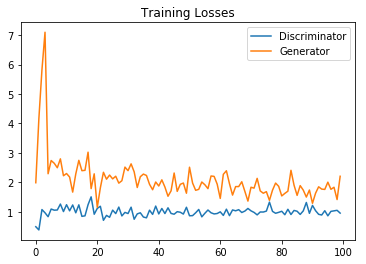

In [12]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Generator samples from training

Here we can view samples of images from the generator. First we'll look at images taken while training.
> 在这里，我们可以查看来自发生器的图像样本。 首先我们来看看训练时拍摄的图像。

In [13]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

In [14]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

These are samples from the final training epoch. You can see the generator is able to reproduce numbers like 5, 7, 3, 0, 9. Since this is just a sample, it isn't representative of the full range of images this generator can make.
> 这些是来自最终训练时期的样本。 你可以看到发生器能够重现像5,7,3,0,9这样的数字。由于这只是一个示例，它并不能代表该发生器可以制作的全部图像。

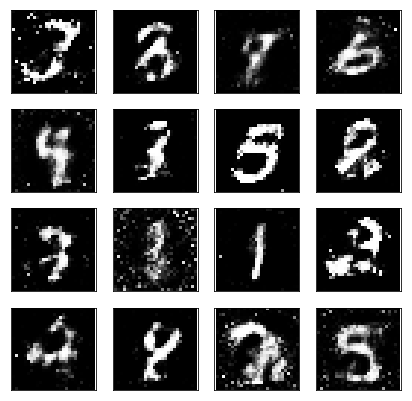

In [15]:
_ = view_samples(-1, samples)

Below I'm showing the generated images as the network was training, every 10 epochs. With bonus optical illusion!
> 下面我展示了网络正在训练的生成图像，每10个时代。 凭借奖金光学幻觉！

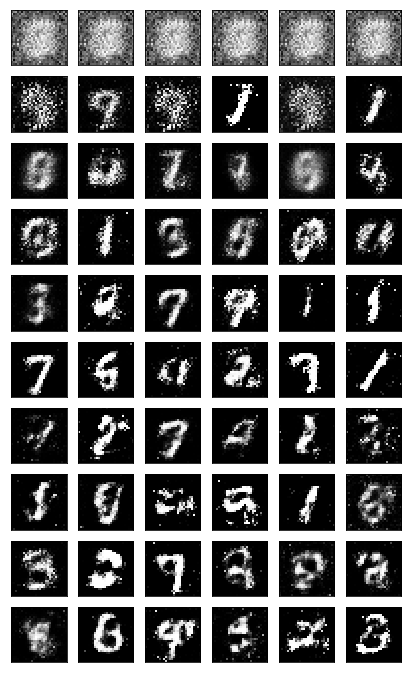

In [16]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

It starts out as all noise. Then it learns to make only the center white and the rest black. You can start to see some number like structures appear out of the noise. Looks like 1, 9, and 8 show up first. Then, it learns 5 and 3.
> 它开始像所有的噪音。 然后它学会只使中心白色，其余的黑色。 你可以开始看到一些像噪音结构的数字。 看起来像1，9和8先出现。 然后学习5和3。

## Sampling from the generator

We can also get completely new images from the generator by using the checkpoint we saved after training. We just need to pass in a new latent vector $z$ and we'll get new samples!
> 通过使用训练后保存的检查点，我们还可以从生成器中获得全新的图像。 我们只需要传入一个新的潜在向量zz，我们将获得新的样本！

INFO:tensorflow:Restoring parameters from checkpoints/generator.ckpt


(<matplotlib.figure.Figure at 0x11ecbcba8>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c2228d0>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x116882ba8>]], dtype=object))

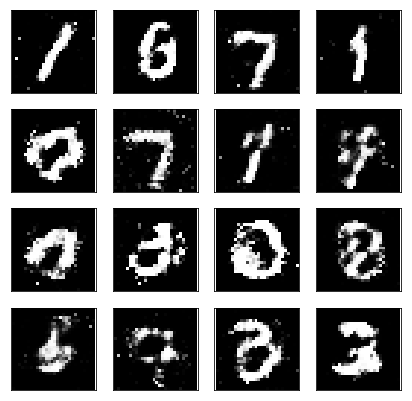

In [17]:
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_z = np.random.uniform(-1, 1, size=(16, z_size))
    gen_samples = sess.run(
                   generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                   feed_dict={input_z: sample_z})
view_samples(0, [gen_samples])